In [65]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [66]:
from datetime import datetime, timedelta, date

def get_first_sunday_of_november(year):
    """Gets the first Sunday of November for a given year."""
    date = datetime(year, 11, 1)
    while date.weekday() != 6:  # 6 represents Sunday
        date += timedelta(days=1)
    return date

def get_second_sunday_of_october(year):
    """
    Gets the second Sunday of October for a given year unless the first Sunday 
    is October 7, in which case it returns the first Sunday.
    """
    date = datetime(year, 10, 1)
    count = 0

    while count < 2:
        if date.weekday() == 6:  # Sunday
            count += 1
            if count == 1 and date.day == 7:  # Special case: first Sunday is October 7
                return date
        if count < 2:
            date += timedelta(days=1)
    
    return date

def get_third_monday_in_april(year):
    """Gets the third Monday in April for a given year."""
    date = datetime(year, 4, 1)
    count = 0
    while count < 3:
        if date.weekday() == 0:  # Monday
            count += 1
        if count < 3:
            date += timedelta(days=1)
    return date

def get_third_sunday_in_march(year):
    """Gets the third Sunday in March for a given year."""
    date = datetime(year, 3, 1)
    count = 0
    while count < 3:
        if date.weekday() == 6:  # Sunday
            count += 1
        if count < 3:
            date += timedelta(days=1)
    return date

def get_second_sunday_in_december(year):
    """Gets the second Sunday in December for a given year."""
    date = datetime(year, 12, 1)
    count = 0
    while count < 2:
        if date.weekday() == 6:  # Sunday
            count += 1
        if count < 2:
            date += timedelta(days=1)
    return date

def get_last_sunday_in_october(year):
    """Gets the last Sunday in October for a given year."""
    date = datetime(year, 10, 31)
    while date.weekday() != 6:  # Sunday
        date -= timedelta(days=1)
    return date

def get_second_sunday_in_january(year):
    """Gets the second Sunday in January, unless the first Sunday is January 7, then returns the first Sunday."""
    date = datetime(year, 1, 1)
    count = 0
    while count < 2:
        if date.weekday() == 6:  # Sunday
            count += 1
            if count == 1 and date.day == 7:  # Special case
                return date
        if count < 2:
            date += timedelta(days=1)
    return date

def get_sunday_before_thanksgiving(year):
    """
    Gets the Sunday before Thanksgiving for a given year.
    Thanksgiving is on the fourth Thursday of November.
    """
    # Find the fourth Thursday of November
    thanksgiving = datetime(year, 11, 1)
    thursday_count = 0

    while thursday_count < 4:
        if thanksgiving.weekday() == 3:  # Thursday
            thursday_count += 1
        if thursday_count < 4:
            thanksgiving += timedelta(days=1)

    # Calculate the Sunday before Thanksgiving
    sunday_before = thanksgiving - timedelta(days=4)  # Go back 4 days to the previous Sunday
    return sunday_before


def get_first_or_second_sunday_in_december(year):
    """
    Gets the first Sunday in December unless December 1 is a Sunday,
    in which case it returns the second Sunday.
    """
    date = datetime(year, 12, 1)
    
    # Check if December 1st is a Sunday
    if date.weekday() == 6:  # If December 1 is a Sunday
        date += timedelta(days=7)  # Move to the second Sunday
    else:
        # Otherwise, find the first Sunday
        days_to_sunday = (6 - date.weekday()) % 7
        date += timedelta(days=days_to_sunday)
    
    return date

def get_saturday_of_third_full_weekend_in_june(year):
    """
    Gets the Saturday of the third full weekend in June (weekend defined as Friday-Saturday-Sunday).
    """
    date = datetime(year, 6, 1)
    count = 0
    while count < 3:
        if date.weekday() == 4:  # Friday
            # Check if it's a full weekend (Friday-Saturday-Sunday)
            if (date + timedelta(days=1)).month == 6 and (date + timedelta(days=2)).month == 6:
                count += 1
        if count < 3:
            date += timedelta(days=1)
    
    return date + timedelta(days=1)


def get_third_sunday_in_january(year):
    """Gets the third Sunday in January unless the first Sunday is January 7, then returns the second Sunday."""
    # Start from January 1st
    date = datetime(year, 1, 1)
    
    # Adjust date to the first Sunday in January
    while date.weekday() != 6:  # 6 corresponds to Sunday
        date += timedelta(days=1)

    # If the first Sunday is January 7, return the second Sunday
    if date.day == 7:
        return date + timedelta(days=7)  # Move to the second Sunday
    
    # Otherwise, return the third Sunday
    return date + timedelta(weeks=2)


In [67]:
import numpy as np
from timezonefinder import TimezoneFinder
import pandas as pd
from meteostat import Point, Hourly

def get_timezone(lat, long):
    tf = TimezoneFinder()
    return tf.timezone_at(lng=long, lat=lat)

def convert_utc_to_timezone(df, utc_column, lat, long):
    timezone = get_timezone(lat, long)
    df = df.copy()  # Ensure we're working with a copy to avoid the SettingWithCopyWarning
    df[utc_column] = pd.to_datetime(df[utc_column], utc=True)
    df['local_datetime'] = df[utc_column].dt.tz_convert(timezone)
    df['local_date'] = df['local_datetime'].dt.date
    df['local_time'] = df['local_datetime'].dt.time
    return df

def celsius_to_fahrenheit(celsius):
    """
    Converts a temperature from Celsius to Fahrenheit.
    
    Parameters:
    - celsius (float or int): Temperature in Celsius.
    
    Returns:
    - float: Temperature in Fahrenheit.
    """
    return (celsius * 9/5) + 32

def get_marathon_weather_data(latitude, longitude, race_time, date_list, marathon_name):
    location = Point(latitude, longitude)
    all_data = []
    
    for day in date_list:
        data = Hourly(location, day, day + timedelta(days=1))
        data = data.fetch()
        
        # Reset index and ensure we are working with a copy to avoid warnings
        data = data.reset_index().copy()
        
        # Convert to local time
        data = convert_utc_to_timezone(data, 'time', latitude, longitude)
        
        race_time_dt = day.replace(hour=race_time)
        race_time_dt_2 = race_time_dt + timedelta(hours=4)
        
        # Filter data based on the race time and 4-hour offset
        data_filter = data[
            ((data['local_date'] == race_time_dt.date()) & (data['local_time'] == race_time_dt.time())) |
            ((data['local_date'] == race_time_dt_2.date()) & (data['local_time'] == race_time_dt_2.time()))
        ].copy()  # Ensure the slice is a copy

        data_filter['temp'] = data_filter['temp'].apply(celsius_to_fahrenheit)
        data_filter['dwpt'] = data_filter['dwpt'].apply(celsius_to_fahrenheit)
        data_filter['wspd'] = data_filter['wspd'] * 0.621371
        data_filter["year"] = pd.to_datetime(data_filter["local_date"]).dt.year
        
        all_data.append(data_filter[['temp', 'rhum', 'dwpt', 'prcp', 'wspd', 'local_date', 'local_time', 'year']])

    # Concatenate all dataframes into one
    weather_data = pd.concat(all_data)

    # Add suffix based on the local time
    weather_data['suffix'] = np.where(weather_data['local_time'] == race_time_dt.time(), '_start', '_start_plus_4')

    # Pivot the dataframe
    weather_pivot = (
        weather_data.set_index(['local_date', 'year', 'suffix'])  # Set local_date and suffix as the index
        .unstack('suffix')  # Pivot based on the suffix
    )

    # Flatten multi-level columns and rename them
    weather_pivot.columns = [f"{col[0]}{col[1]}" for col in weather_pivot.columns]

    # Reset the index for a clean result
    weather_pivot.reset_index(inplace=True)

    # Calculate mean values and add marathon name
    weather_agg = weather_pivot.drop(columns=['local_time_start', 'local_time_start_plus_4', 'local_date']).agg(['mean','min','max','std']).reset_index()
    weather_agg['marathon_name'] = marathon_name
    weather_pivot['marathon_name'] = marathon_name

    return weather_pivot, weather_agg

In [68]:
# Get race dates
nyc_dates = []
for year in range(date.today().year - 20, date.today().year):
    nyc_dates.append(get_first_sunday_of_november(year))

chicago_dates = []
for year in range(date.today().year - 20, date.today().year):
    chicago_dates.append(get_second_sunday_of_october(year))

boston_dates = []
for year in range(date.today().year - 20, date.today().year):
    boston_dates.append(get_third_monday_in_april(year))

la_dates = []
for year in range(date.today().year - 20, date.today().year):
    la_dates.append(get_third_sunday_in_march(year))

honolulu_dates = []
for year in range(date.today().year - 20, date.today().year):
    honolulu_dates.append(get_second_sunday_in_december(year))

marine_corps_dates = []
for year in range(date.today().year - 20, date.today().year):
    marine_corps_dates.append(get_last_sunday_in_october(year))

disney_dates = []
for year in range(date.today().year - 20, date.today().year):
    disney_dates.append(get_second_sunday_in_january(year))

philadelphia_dates = []
for year in range(date.today().year - 20, date.today().year):
    philadelphia_dates.append(get_sunday_before_thanksgiving(year))

cim_dates = []
for year in range(date.today().year - 20, date.today().year):
    cim_dates.append(get_first_or_second_sunday_in_december(year))

grandmas_dates = []
for year in range(date.today().year - 20, date.today().year):
    grandmas_dates.append(get_saturday_of_third_full_weekend_in_june(year))

houston_dates = []
for year in range(date.today().year - 20, date.today().year):
    houston_dates.append(get_third_sunday_in_january(year))

In [69]:
nyc, nyc_agg = get_marathon_weather_data(40.7128, -74.0060, 9, nyc_dates, 'NYC')

In [70]:
chicago, chicago_agg = get_marathon_weather_data(41.8781, -87.6298, 7, chicago_dates, 'Chicago')

In [71]:
boston, boston_agg = get_marathon_weather_data(42.3601, -71.0589, 10, boston_dates, 'Boston')

In [72]:
la, la_agg = get_marathon_weather_data(34.0522, -118.2437, 7, la_dates, 'LA')

In [73]:
honolulu, honolulu_agg = get_marathon_weather_data(21.3069, -157.8583, 5, honolulu_dates, 'Honolulu')

In [74]:
marine_corps, marine_corps_agg = get_marathon_weather_data(38.9072, -77.0369, 8, marine_corps_dates, 'Marine Corps')

In [75]:
disney, disney_agg = get_marathon_weather_data(28.5383, -81.3792, 5, disney_dates, 'Disney')

In [76]:
philadelphia, philadelphia_agg = get_marathon_weather_data(39.9526, -75.1652, 7, philadelphia_dates, 'Philadelphia')

In [77]:
cim, cim_agg = get_marathon_weather_data(38.5816, -121.4944, 7, cim_dates, 'CIM')

In [78]:
grandmas, grandmas_agg = get_marathon_weather_data(46.7867, -92.1005, 8, grandmas_dates, 'Grandmas')

In [79]:
houston, houston_agg = get_marathon_weather_data(29.7604, -95.3698, 7, houston_dates, 'Houston')

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_yearly_metrics_individually(df):
    metrics = ["temp", "dwpt", "wspd"]
    df_long = pd.melt(
        df,
        id_vars=["year"],
        value_vars=[f"{metric}_start" for metric in metrics] + [f"{metric}_start_plus_4" for metric in metrics],
        var_name="metric",
        value_name="value",
    )

    # Extract time information (start or start_plus_4) from the 'metric' column
    df_long["time"] = df_long["metric"].apply(lambda x: "Start" if "start" in x and "plus_4" not in x else "Start + 4 Hours")
    df_long["metric"] = df_long["metric"].str.split("_").str[0]  # Keep only the metric name (temp, dwpt, wspd)

    # Plot each metric individually
    sns.set_theme(style="whitegrid")

    for metric in metrics:
        metric_data = df_long[df_long["metric"] == metric]
        
        plt.figure(figsize=(12, 6))
        sns.barplot(
            data=metric_data,
            x="year",
            y="value",
            hue="time",
            palette="Set2",
        )
        
        # Add data labels rounded to the nearest integer
        ax = plt.gca()  # Get the current axes
        for container in ax.containers:
            ax.bar_label(
                container,
                fmt="%.0f",
                label_type="edge",
                fontsize=10,
                padding=3,
            )
        
        # Customizations
        plt.title(f"{metric.capitalize()} by Year - {df['marathon_name'][0]}")
        plt.ylabel(f"{metric.capitalize()}")
        plt.xlabel("Year")
        plt.legend(title="Time", loc="upper left")
        plt.figure(dpi=300)
        
        plt.tight_layout()
        plt.show()

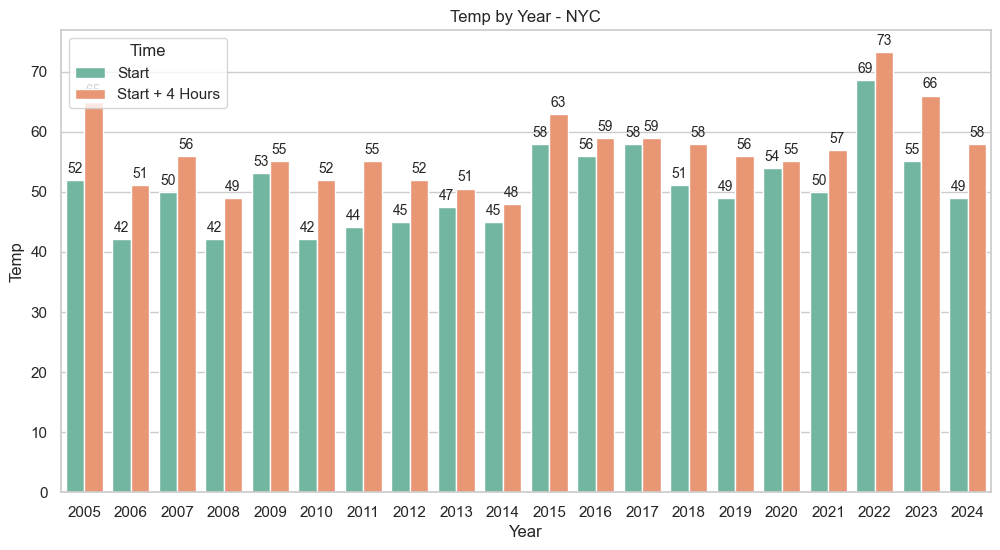

<Figure size 1920x1440 with 0 Axes>

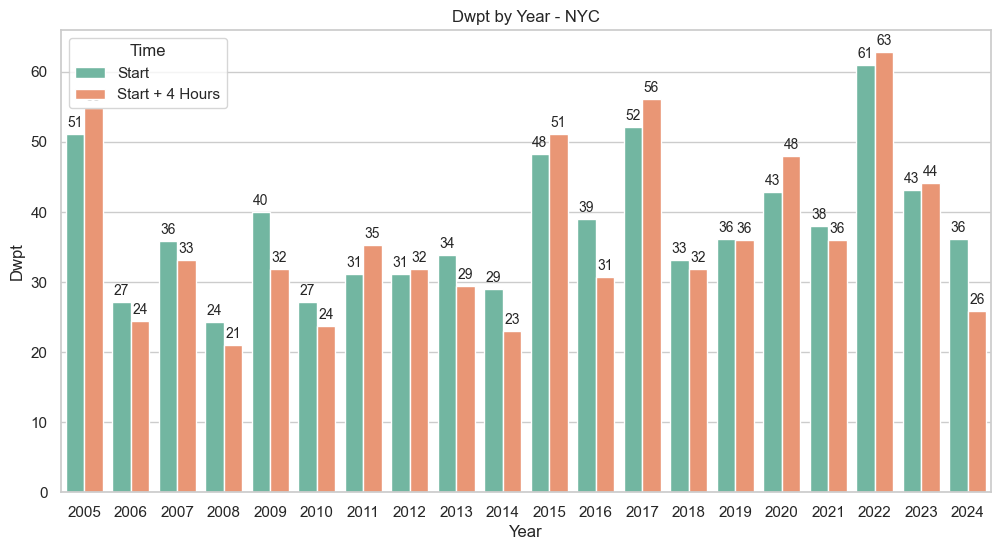

<Figure size 1920x1440 with 0 Axes>

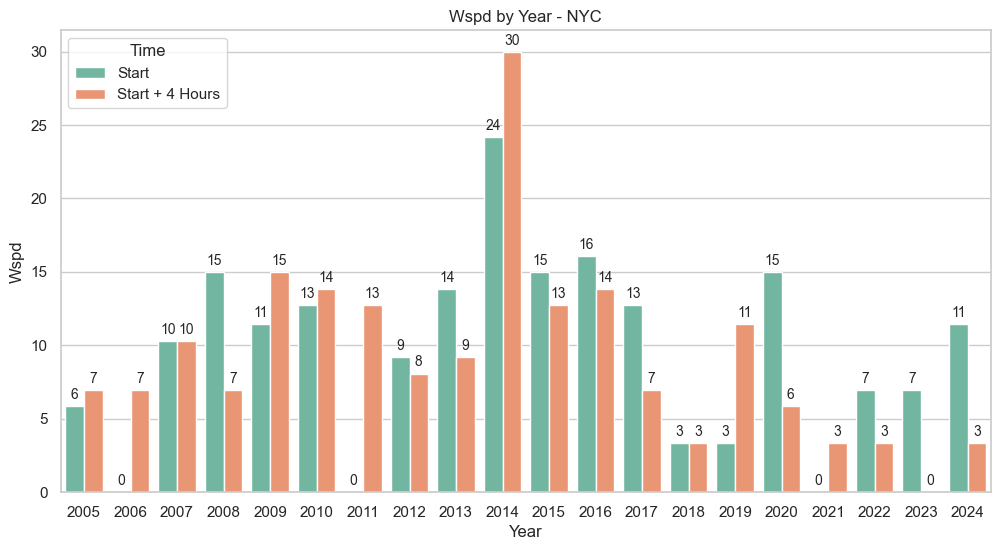

<Figure size 1920x1440 with 0 Axes>

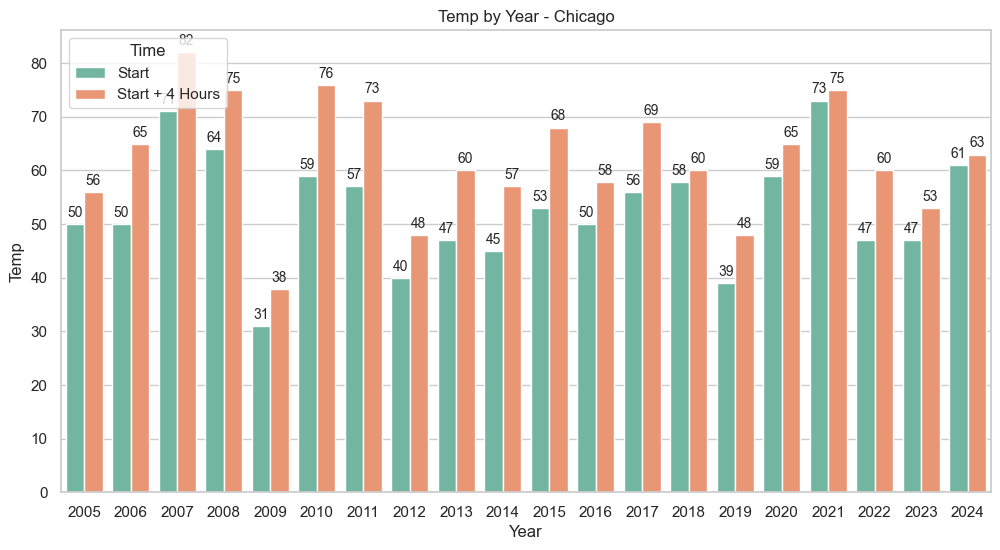

<Figure size 1920x1440 with 0 Axes>

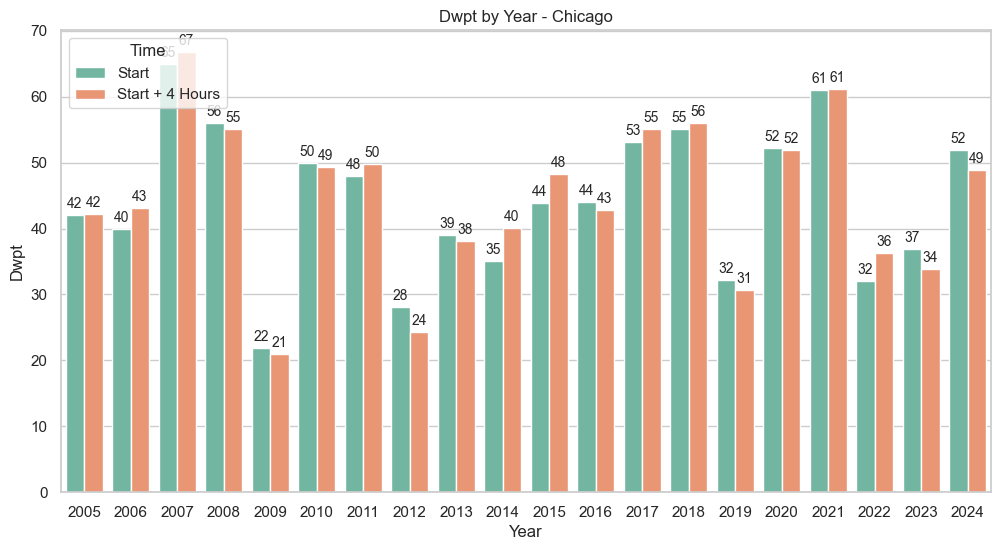

<Figure size 1920x1440 with 0 Axes>

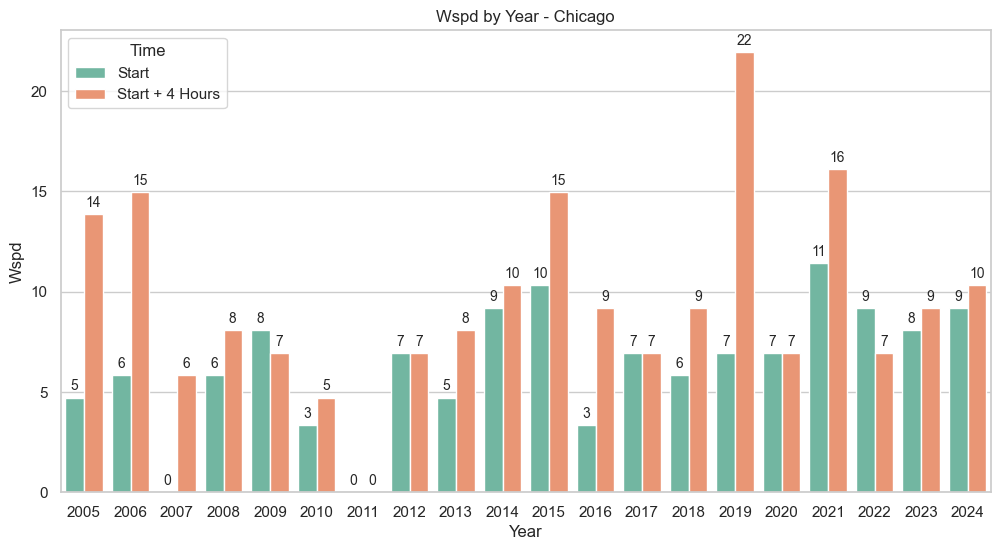

<Figure size 1920x1440 with 0 Axes>

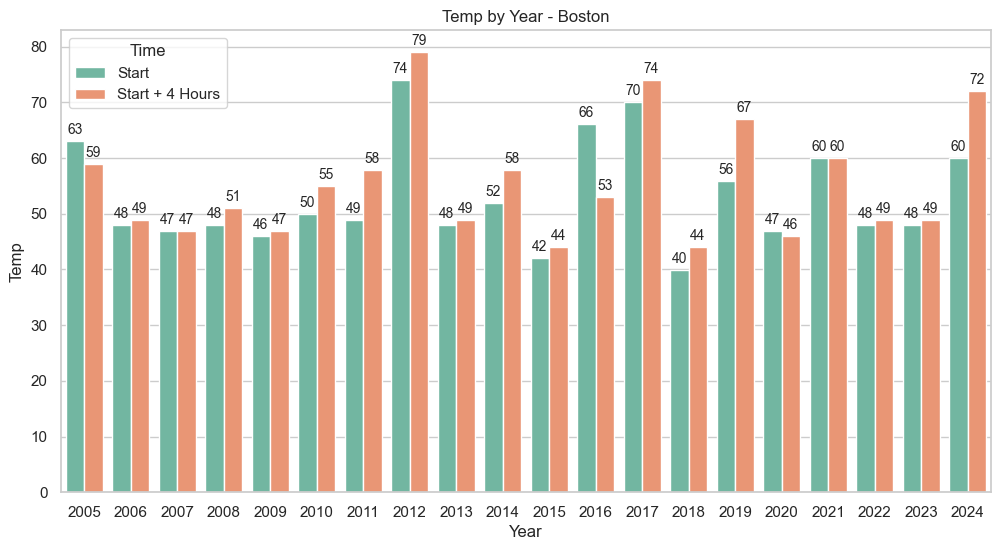

<Figure size 1920x1440 with 0 Axes>

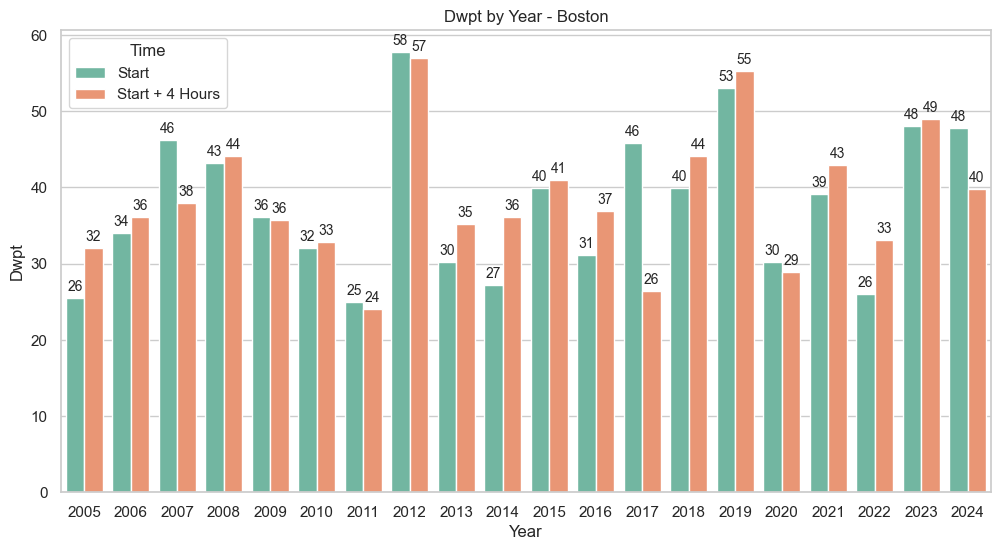

<Figure size 1920x1440 with 0 Axes>

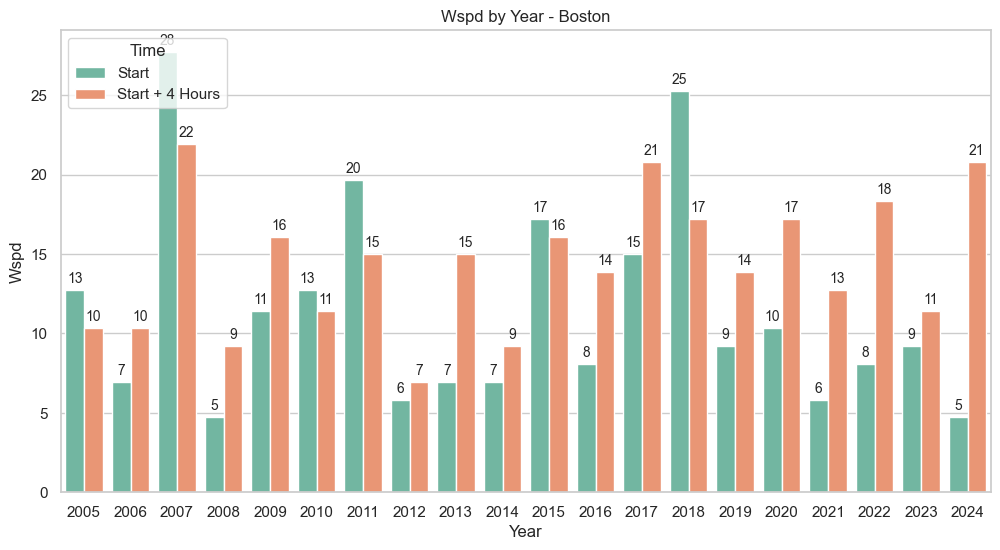

<Figure size 1920x1440 with 0 Axes>

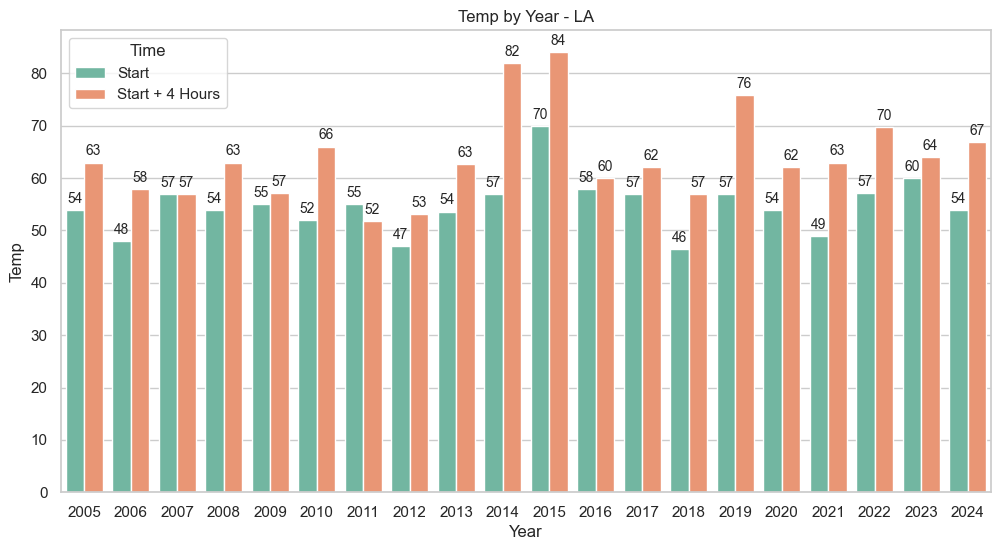

<Figure size 1920x1440 with 0 Axes>

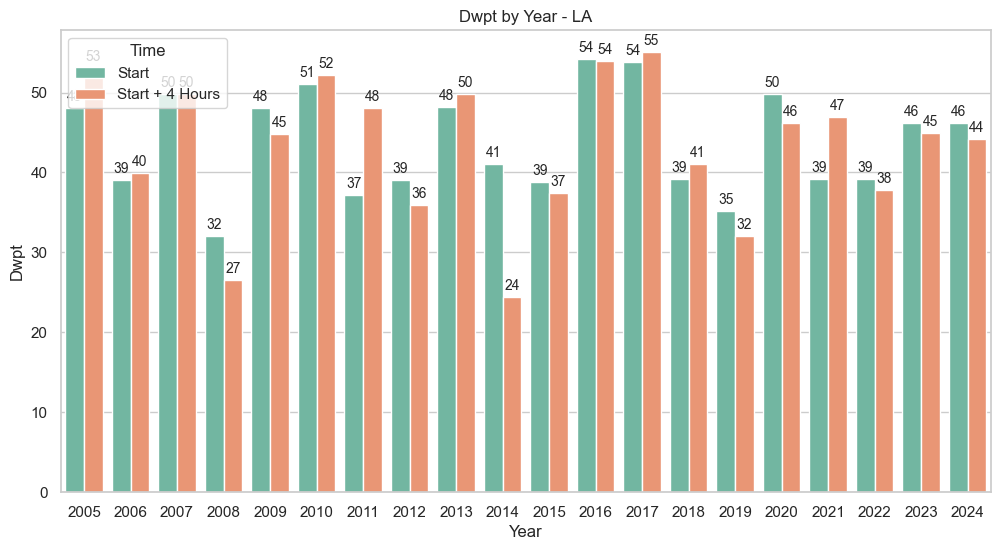

<Figure size 1920x1440 with 0 Axes>

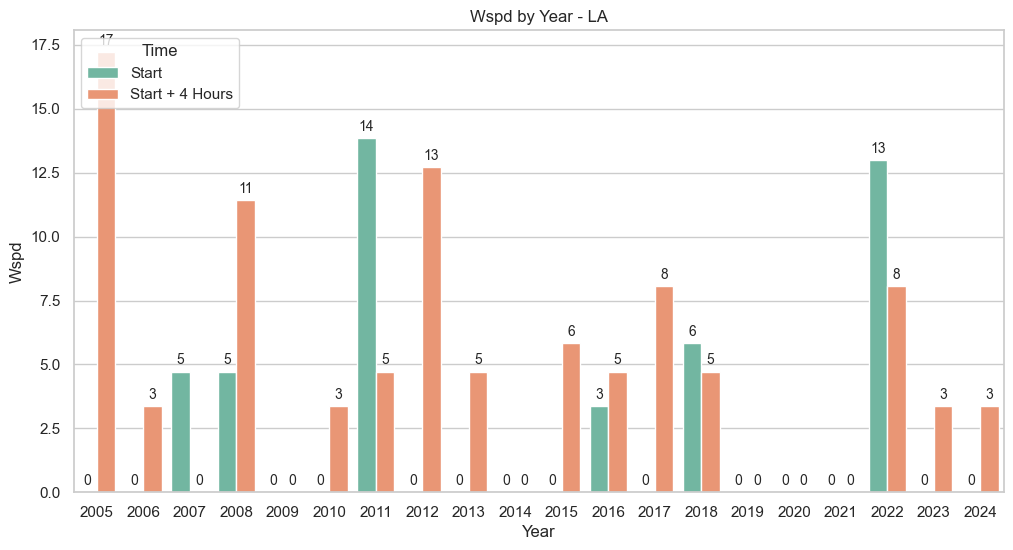

<Figure size 1920x1440 with 0 Axes>

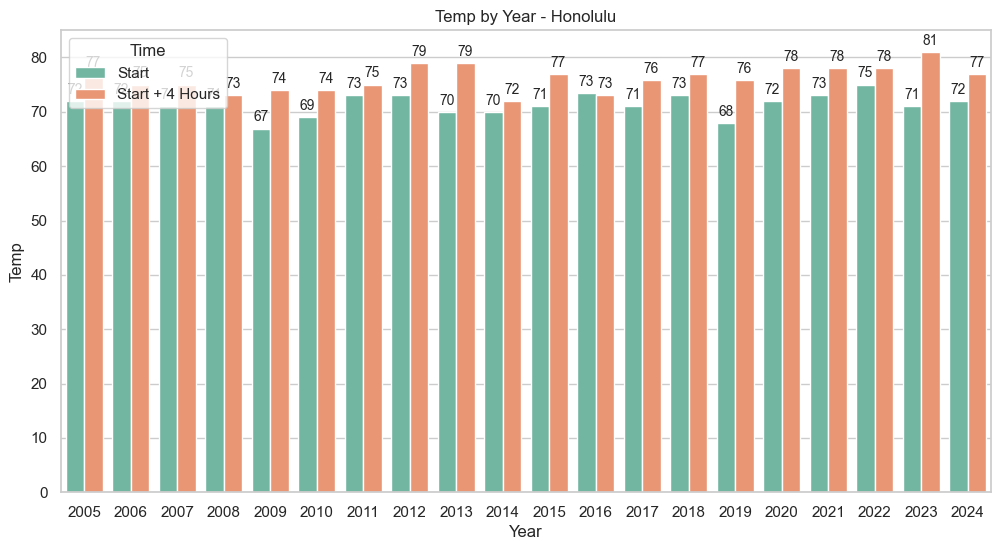

<Figure size 1920x1440 with 0 Axes>

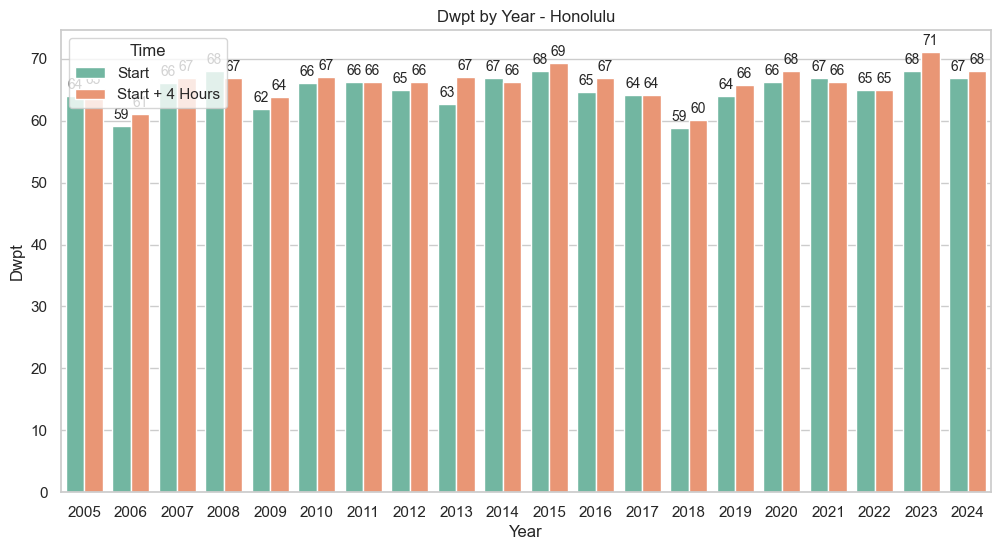

<Figure size 1920x1440 with 0 Axes>

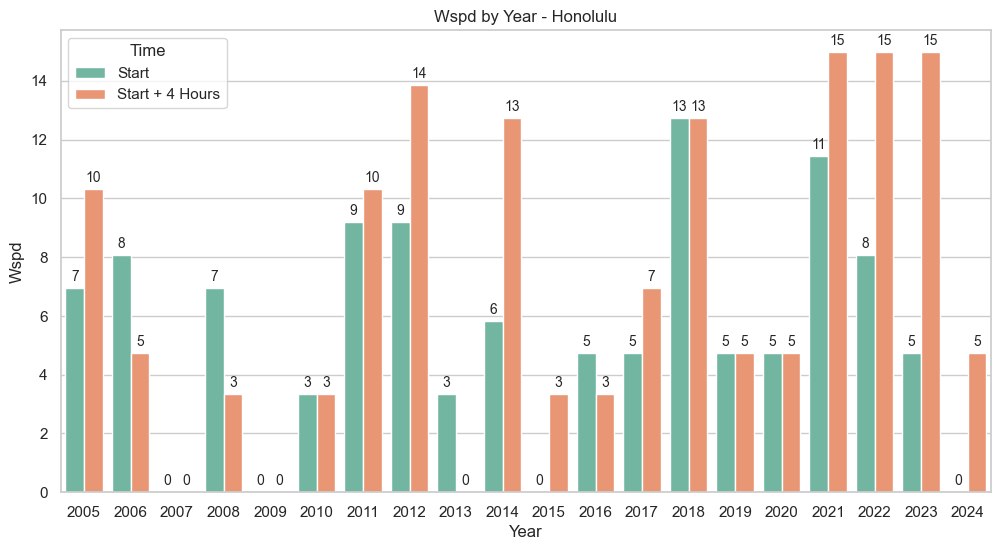

<Figure size 1920x1440 with 0 Axes>

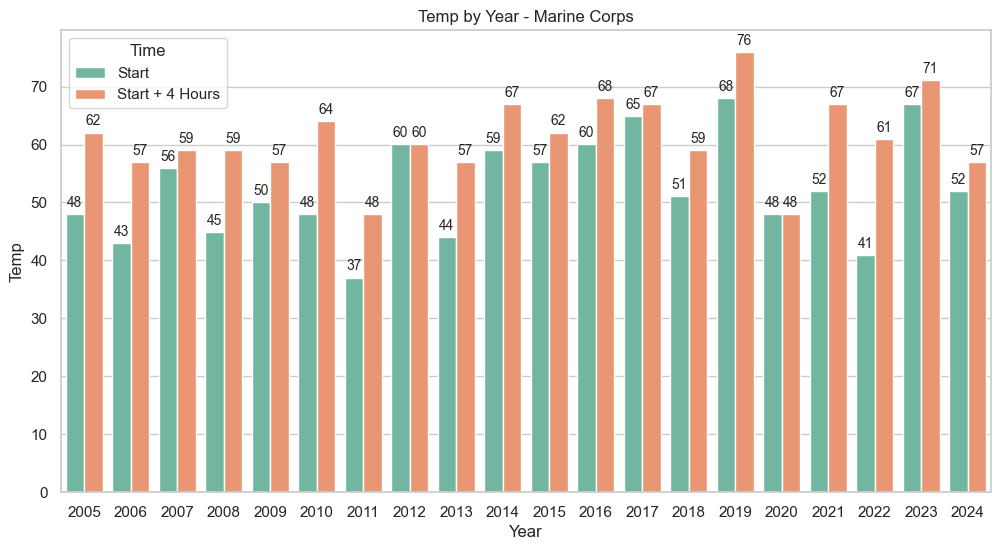

<Figure size 1920x1440 with 0 Axes>

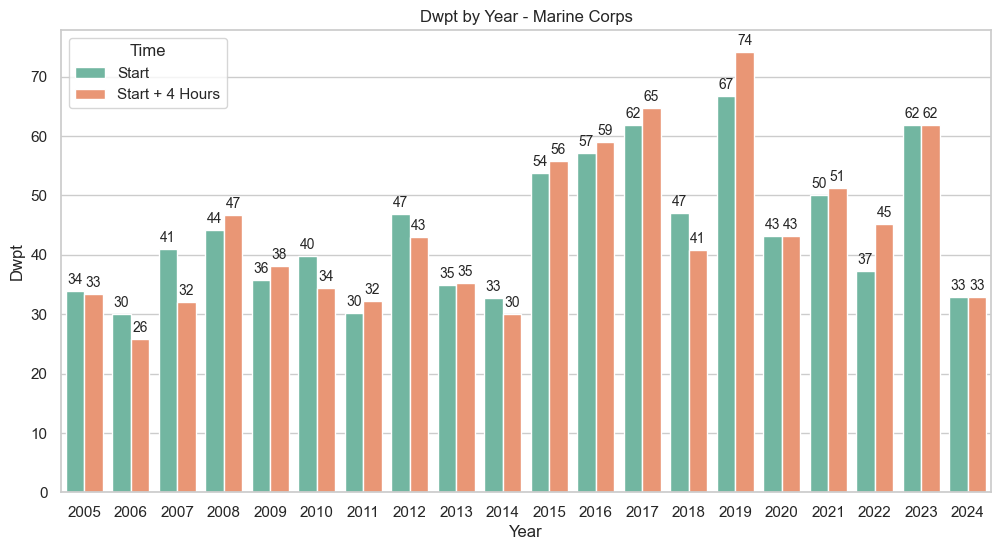

<Figure size 1920x1440 with 0 Axes>

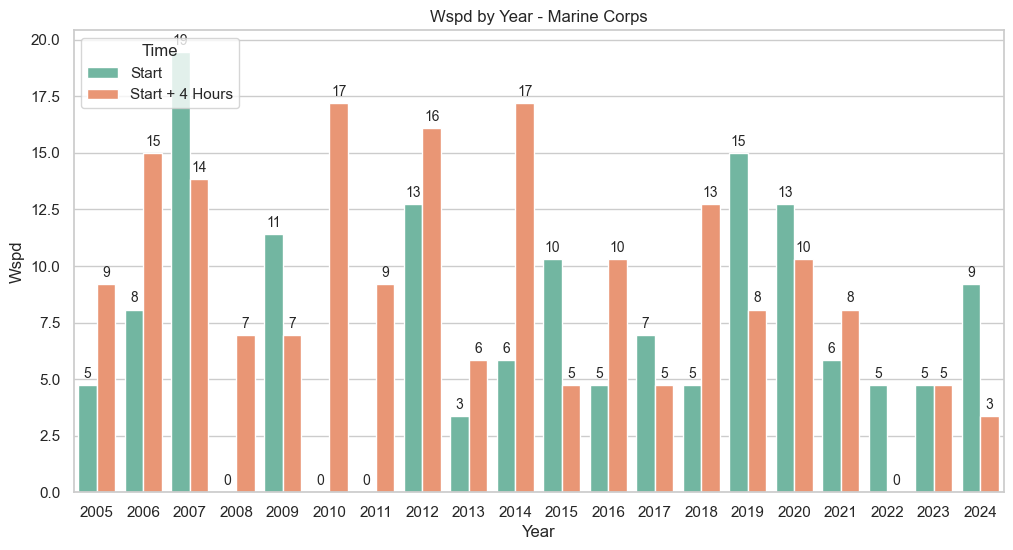

<Figure size 1920x1440 with 0 Axes>

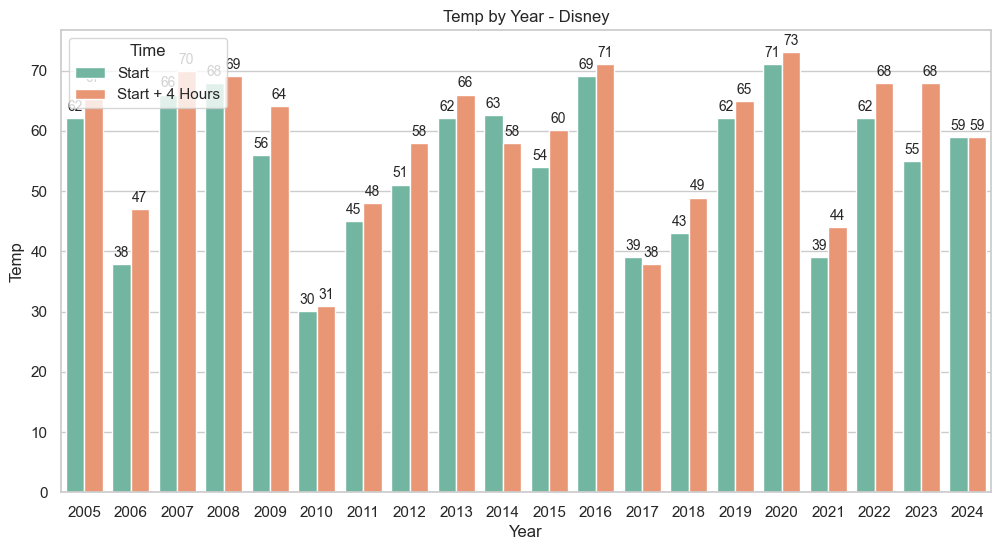

<Figure size 1920x1440 with 0 Axes>

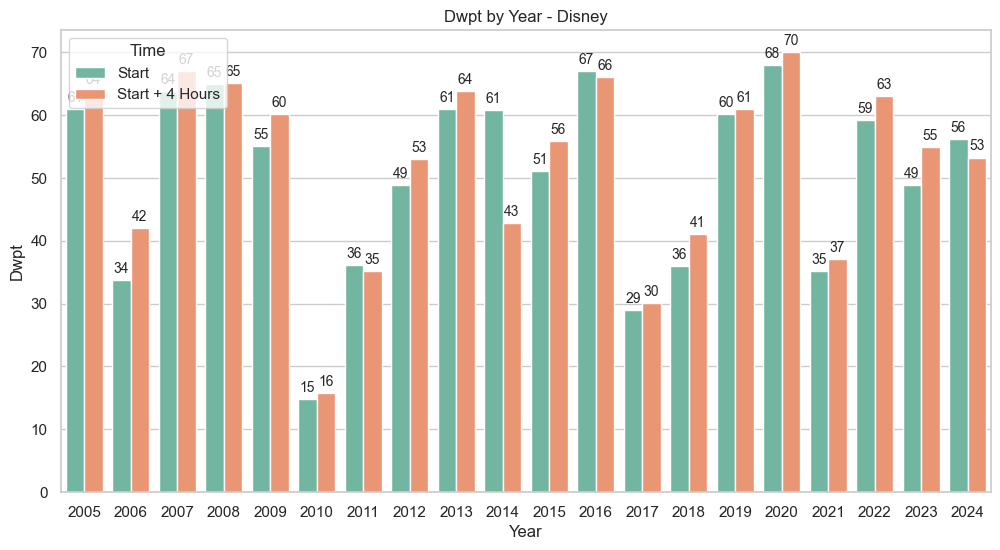

<Figure size 1920x1440 with 0 Axes>

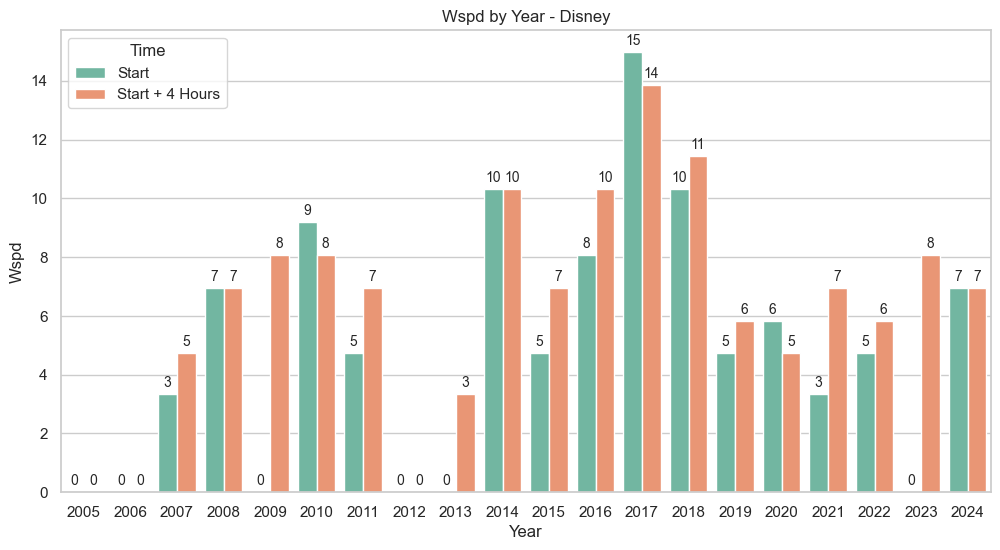

<Figure size 1920x1440 with 0 Axes>

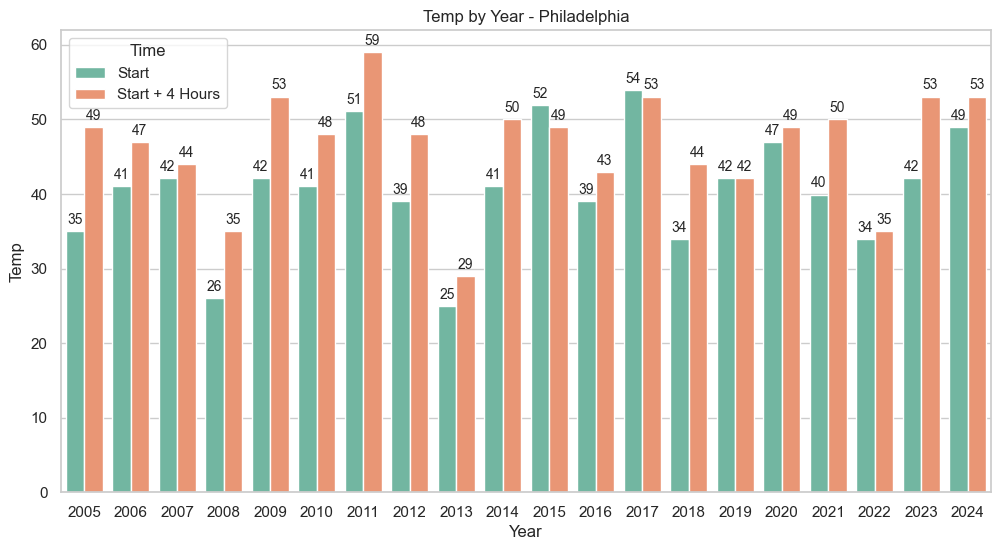

<Figure size 1920x1440 with 0 Axes>

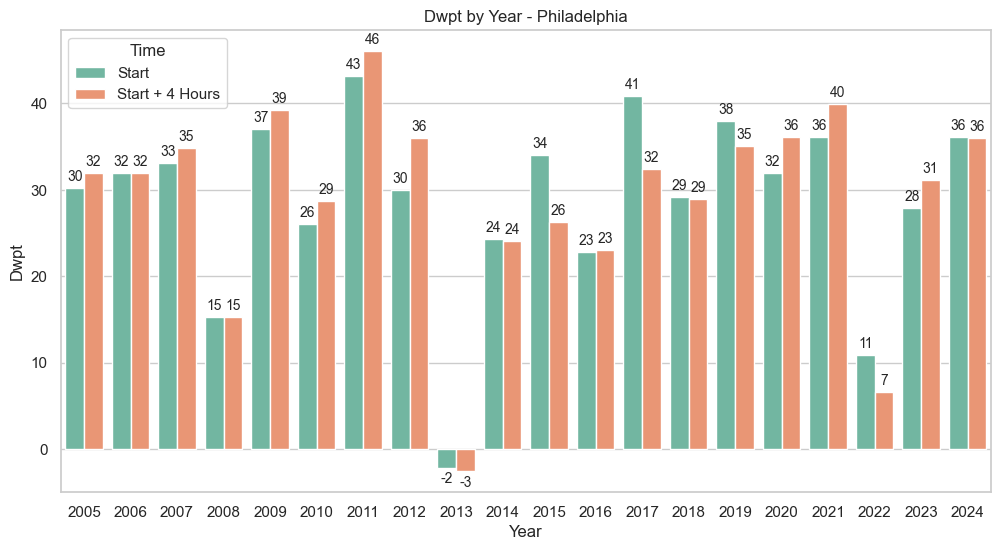

<Figure size 1920x1440 with 0 Axes>

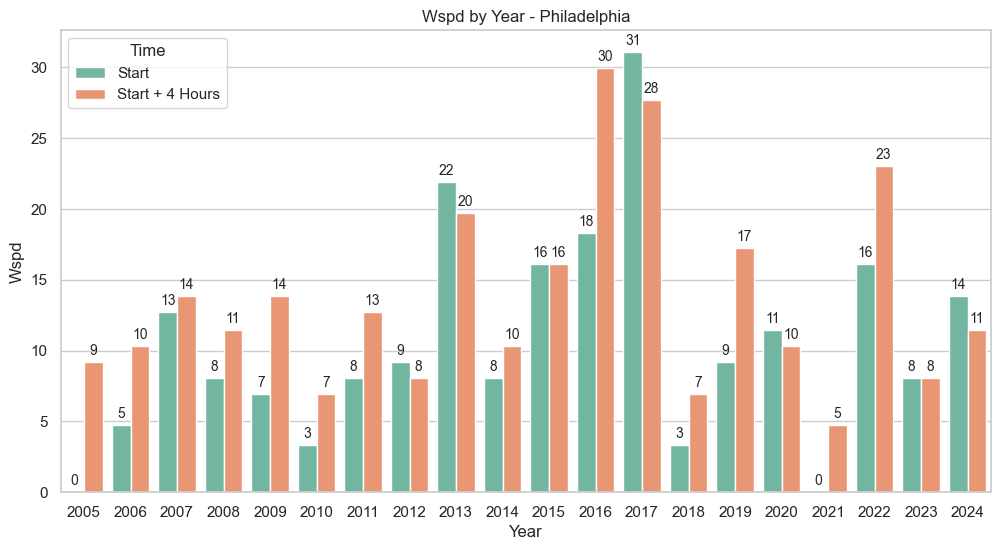

<Figure size 1920x1440 with 0 Axes>

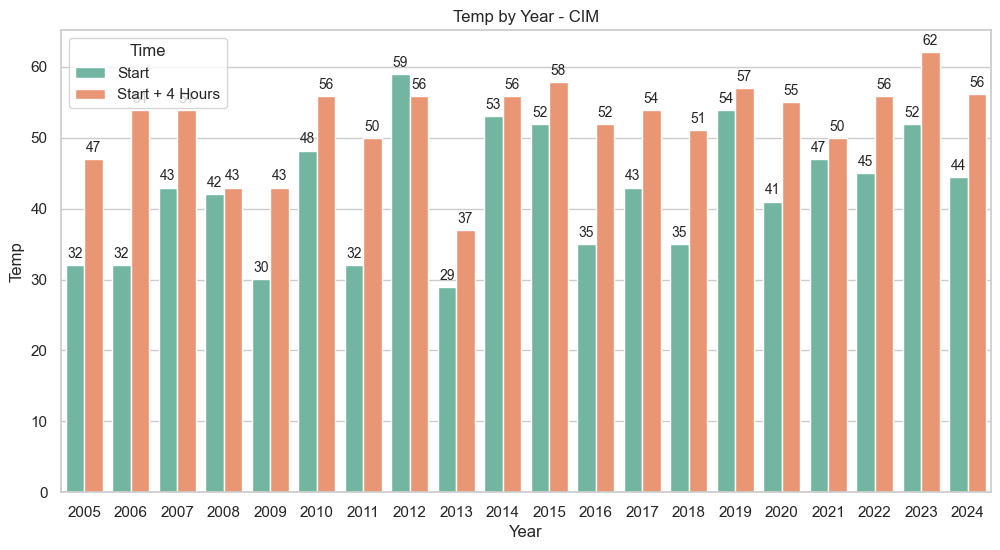

<Figure size 1920x1440 with 0 Axes>

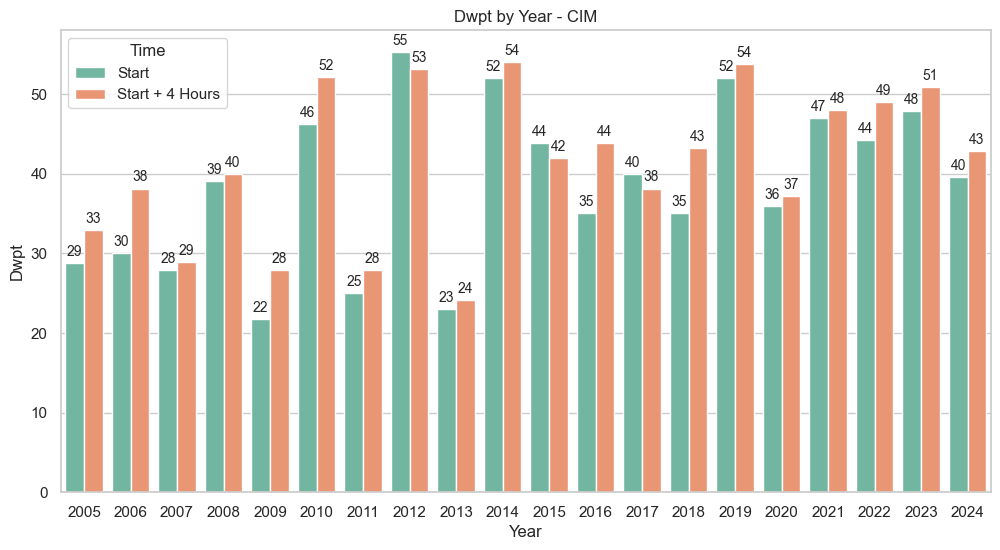

<Figure size 1920x1440 with 0 Axes>

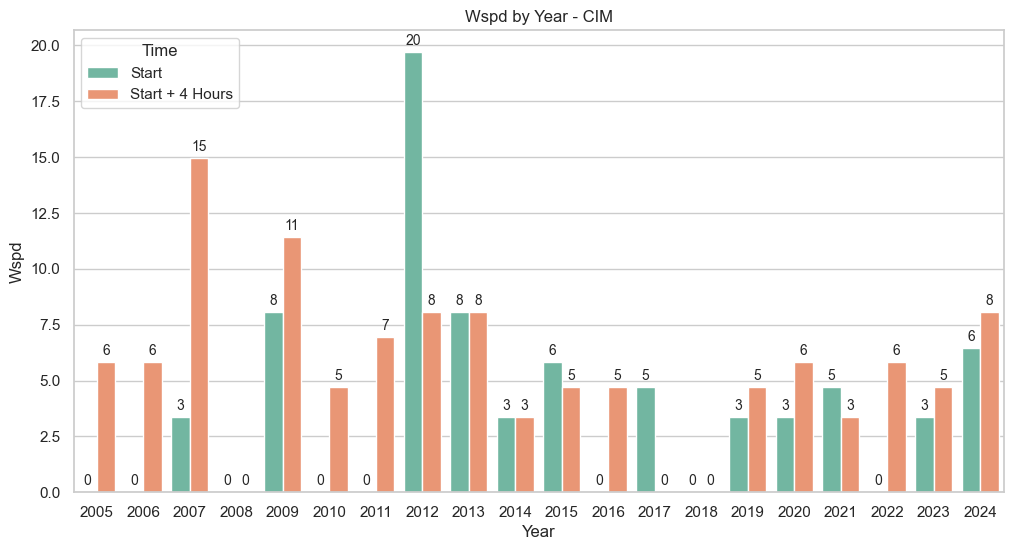

<Figure size 1920x1440 with 0 Axes>

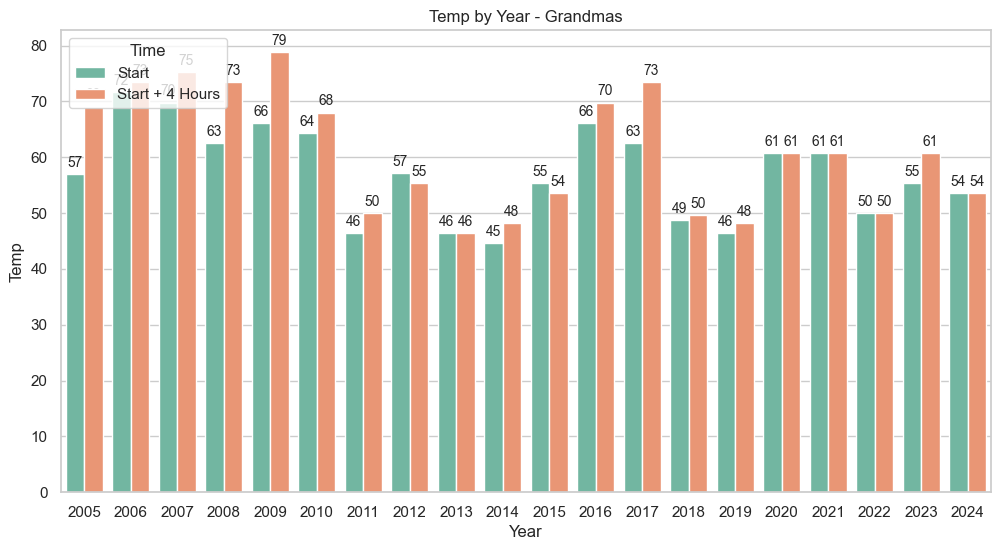

<Figure size 1920x1440 with 0 Axes>

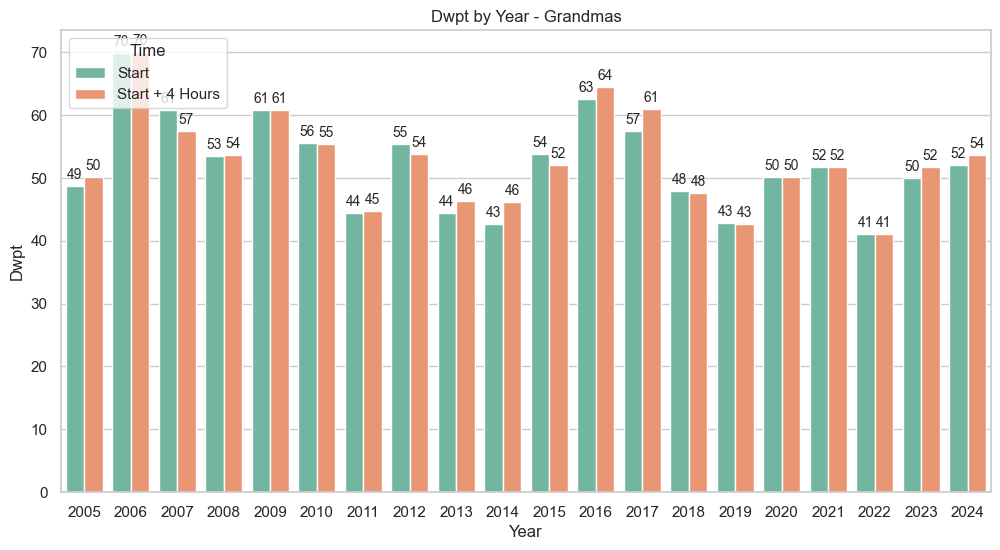

<Figure size 1920x1440 with 0 Axes>

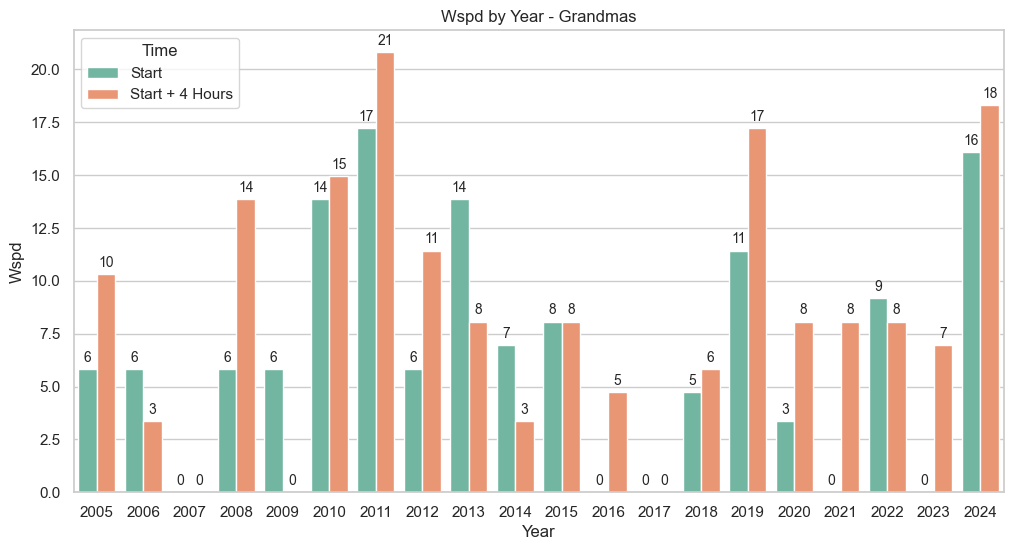

<Figure size 1920x1440 with 0 Axes>

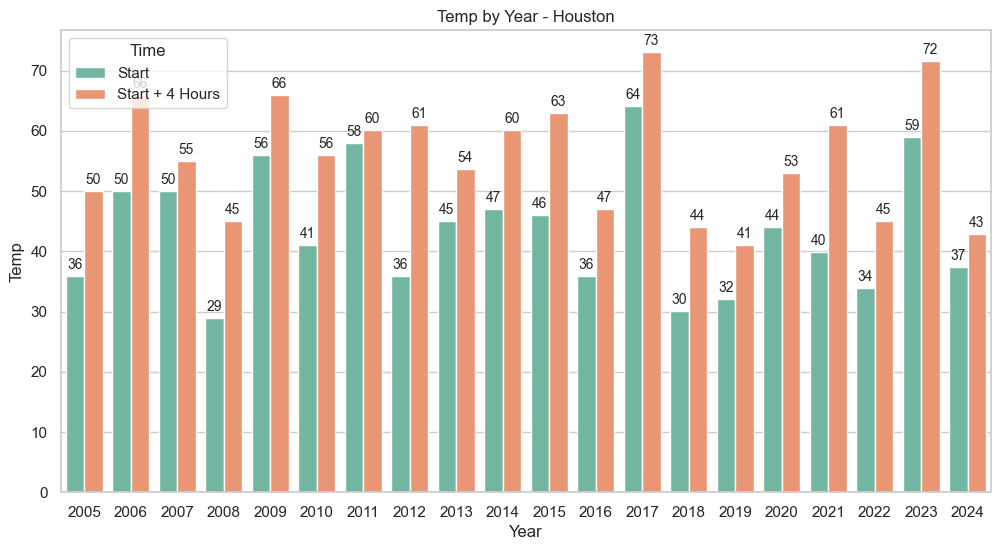

<Figure size 1920x1440 with 0 Axes>

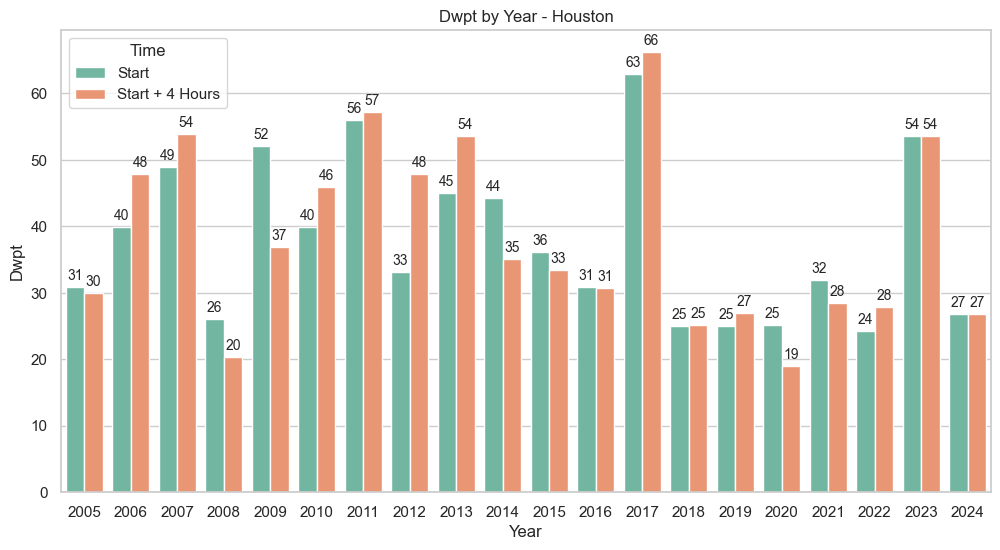

<Figure size 1920x1440 with 0 Axes>

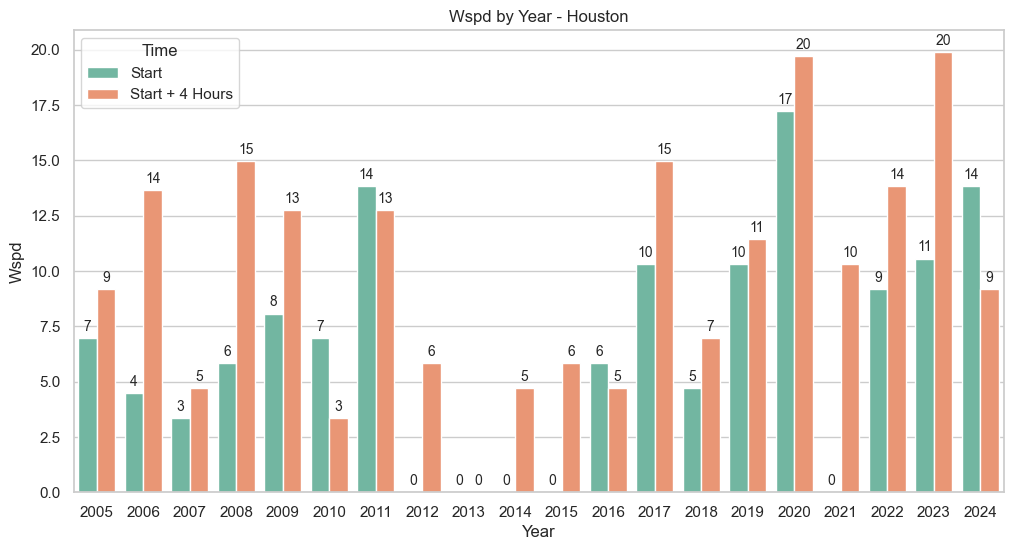

<Figure size 1920x1440 with 0 Axes>

In [81]:
for df in [nyc, chicago, boston, la, honolulu, marine_corps, disney, philadelphia, cim, grandmas, houston]:
    plot_yearly_metrics_individually(df)

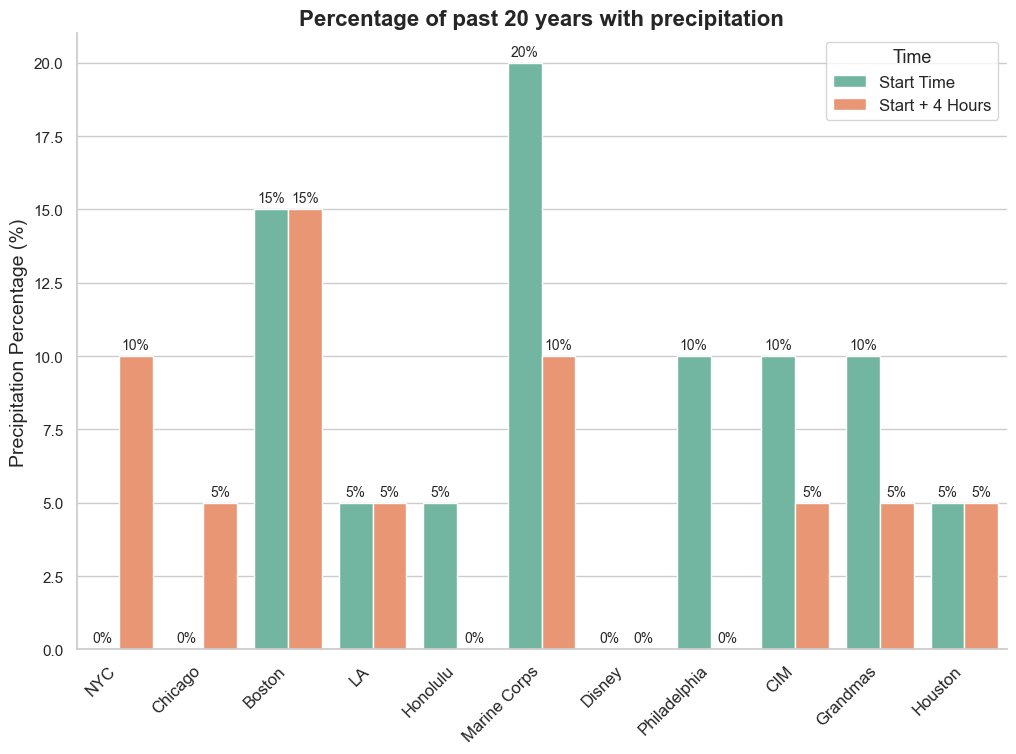

<Figure size 1920x1440 with 0 Axes>

In [82]:
def calculate_precipitation_percentages(df):
    """Calculate the percentage of years with precipitation at start and start + 4 hours."""
    prcp_start_count = (df["prcp_start"] > 0).sum()
    prcp_start_plus_4_count = (df["prcp_start_plus_4"] > 0).sum()

    total_years = len(df)
    prcp_start_percentage = prcp_start_count / total_years * 100
    prcp_start_plus_4_percentage = prcp_start_plus_4_count / total_years * 100

    return {
        "marathon_name": df["marathon_name"].iloc[0],
        "prcp_start": prcp_start_percentage,
        "prcp_start_plus_4": prcp_start_plus_4_percentage,
    }

# List of marathon dataframes
marathon_dataframes = [nyc, chicago, boston, la, honolulu, marine_corps, disney, philadelphia, cim, grandmas, houston]

# Collect precipitation percentages
precipitation_data = [calculate_precipitation_percentages(df) for df in marathon_dataframes]

# Create a DataFrame for plotting
precipitation_df = pd.DataFrame(precipitation_data)

# Reshape data for grouped bar chart
precipitation_melted = precipitation_df.melt(
    id_vars=["marathon_name"],
    value_vars=["prcp_start", "prcp_start_plus_4"],
    var_name="Time",
    value_name="Precipitation Percentage",
)

# Map readable labels
time_labels = {
    "prcp_start": "Start Time",
    "prcp_start_plus_4": "Start + 4 Hours",
}
precipitation_melted["Time"] = precipitation_melted["Time"].map(time_labels)

# Plot the grouped bar chart
plt.figure(figsize=(12, 8))
sns.barplot(
    data=precipitation_melted,
    x="marathon_name",
    y="Precipitation Percentage",
    hue="Time",
    palette="Set2",
)

# Add data labels
for container in plt.gca().containers:
    plt.bar_label(container, fmt="%.0f%%", fontsize=10, padding=3)

# Customize the plot
plt.title("Percentage of past 20 years with precipitation", fontsize=16, fontweight="bold")
plt.xlabel("")
plt.ylabel("Precipitation Percentage (%)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.legend(title="Time", fontsize=12, title_fontsize=13)
sns.despine()
plt.figure(dpi=300)

plt.tight_layout()
plt.show()

In [83]:
weather_agg = []

for df_agg in [nyc_agg, chicago_agg, boston_agg, la_agg, honolulu_agg, marine_corps_agg, disney_agg, philadelphia_agg, cim_agg, grandmas_agg, houston_agg]:
    weather_agg.append(df_agg)

weather_agg_all = pd.concat(weather_agg)

In [84]:
# Pivot the data
pivot_df = weather_agg_all.pivot_table(
    index='marathon_name',
    columns='index',
    values=[
        'temp_start', 'temp_start_plus_4', 
        'rhum_start', 'rhum_start_plus_4',
        'dwpt_start', 'dwpt_start_plus_4', 
        'wspd_start', 'wspd_start_plus_4'
    ],
    aggfunc='first'
)

In [91]:
def plot_and_save_aggregated_metrics(pivot_df):
    """
    Plots and saves bar charts for aggregated metrics for each marathon.
    """
    metrics = ['temp', 'rhum', 'dwpt', 'wspd']
    aggregations = ['min', 'mean', 'max', 'std']

    for metric in metrics:
        for aggregation in aggregations:
            # Extract the relevant data
            column_name = f"{metric}_start"
            column_name_plus_4 = f"{metric}_start_plus_4"
            y_values = pivot_df[(column_name, aggregation)]
            y_values_plus_4 = pivot_df[(column_name_plus_4, aggregation)]

            # Bar chart setup
            fig, ax = plt.subplots(figsize=(10, 6))
            x_labels = pivot_df.index
            width = 0.35
            x = range(len(x_labels))
            colors = sns.color_palette("Set2", n_colors=2)

            if metric == "std":
                metric = "stdev"

            # Bar plots
            bars1 = ax.bar(
                [pos - width / 2 for pos in x],
                y_values,
                width=width,
                label=f"{metric.capitalize()} Start",
                color=colors[0],
            )
            bars2 = ax.bar(
                [pos + width / 2 for pos in x],
                y_values_plus_4,
                width=width,
                label=f"{metric.capitalize()} Start + 4 Hours",
                color=colors[1],
            )

            # Add data labels for each bar
            for bar in bars1:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.5,
                    f"{height:.0f}",
                    ha="center",
                    va="bottom",
                    fontsize=9,
                )
            for bar in bars2:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.5,
                    f"{height:.0f}",
                    ha="center",
                    va="bottom",
                    fontsize=9,
                )

            # Formatting
            ax.set_xticks(x)
            ax.set_xticklabels(x_labels, rotation=45, ha="right")
            ax.set_ylabel(f"{metric.capitalize()} ({aggregation.capitalize()})")
            ax.set_title(
                f"{metric.capitalize()} ({aggregation.capitalize()}) Comparison",
                fontsize=14,
                fontweight="bold",
            )
            ax.legend()
            sns.despine()
            plt.figure(dpi=300)

            plt.show()

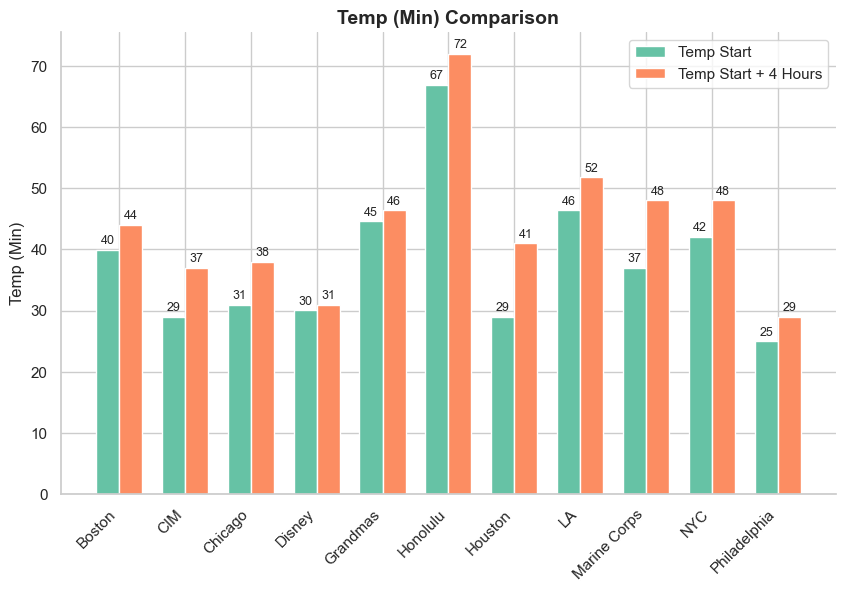

<Figure size 1920x1440 with 0 Axes>

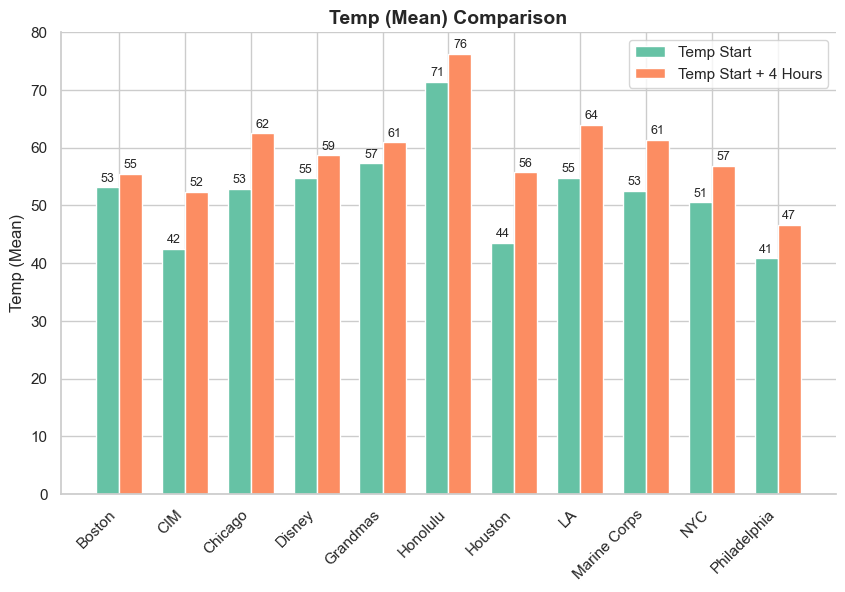

<Figure size 1920x1440 with 0 Axes>

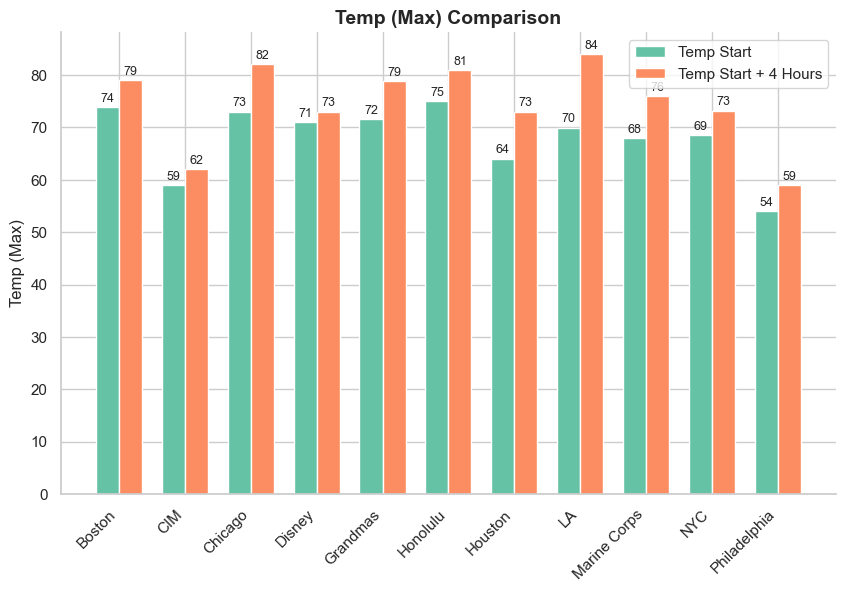

<Figure size 1920x1440 with 0 Axes>

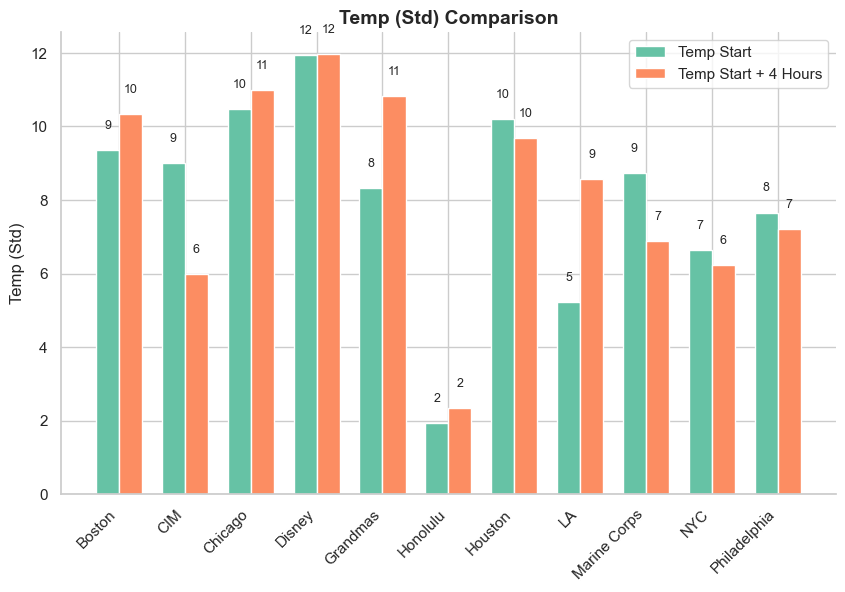

<Figure size 1920x1440 with 0 Axes>

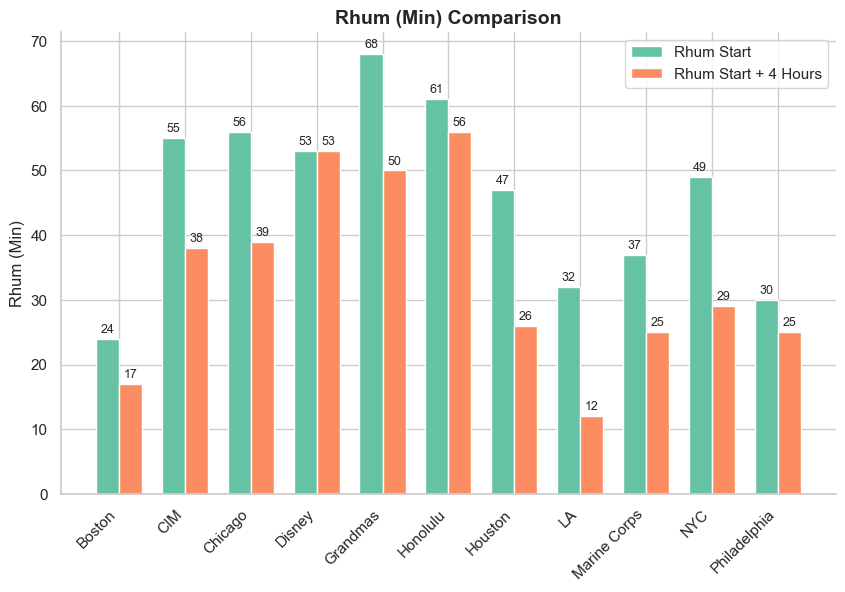

<Figure size 1920x1440 with 0 Axes>

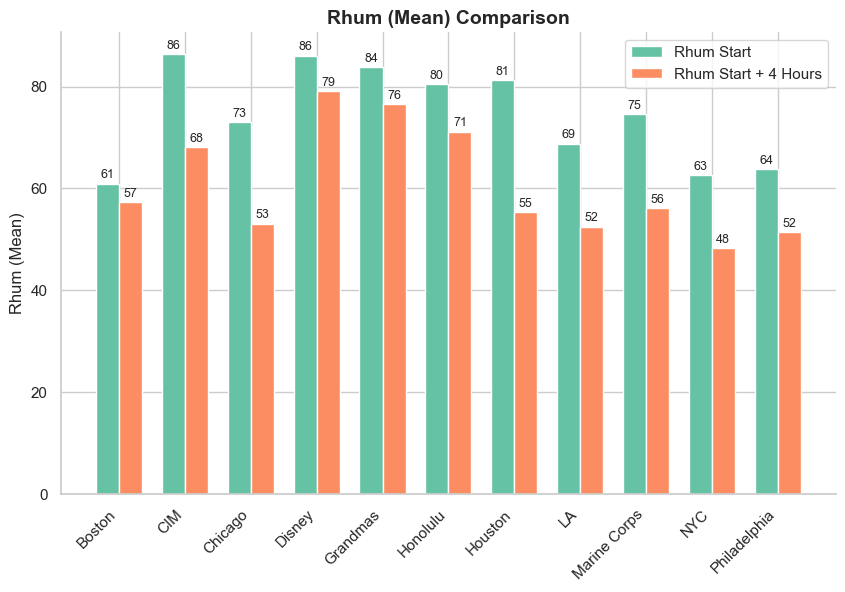

<Figure size 1920x1440 with 0 Axes>

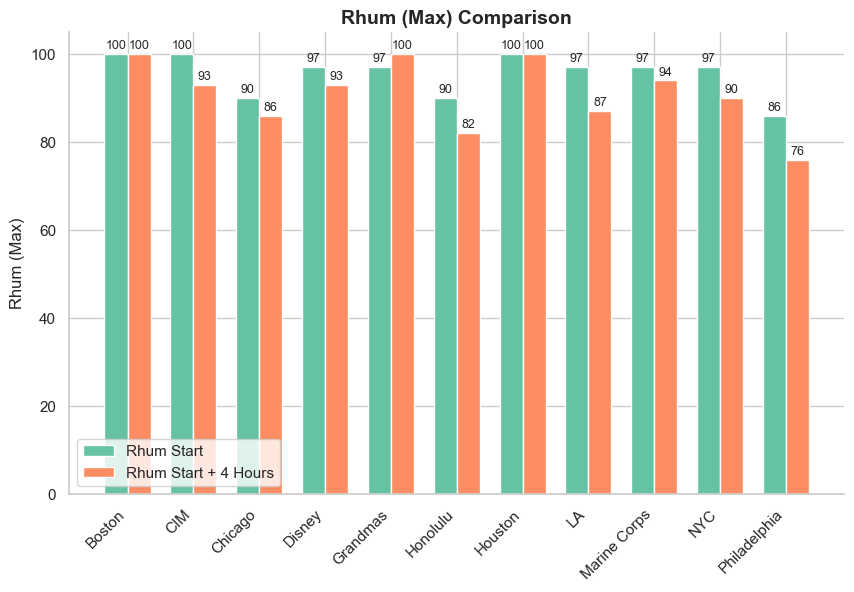

<Figure size 1920x1440 with 0 Axes>

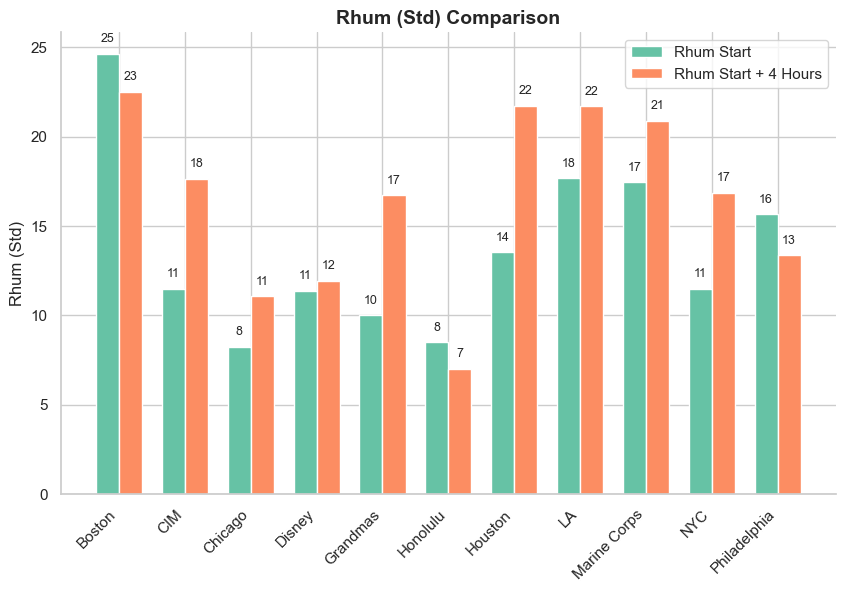

<Figure size 1920x1440 with 0 Axes>

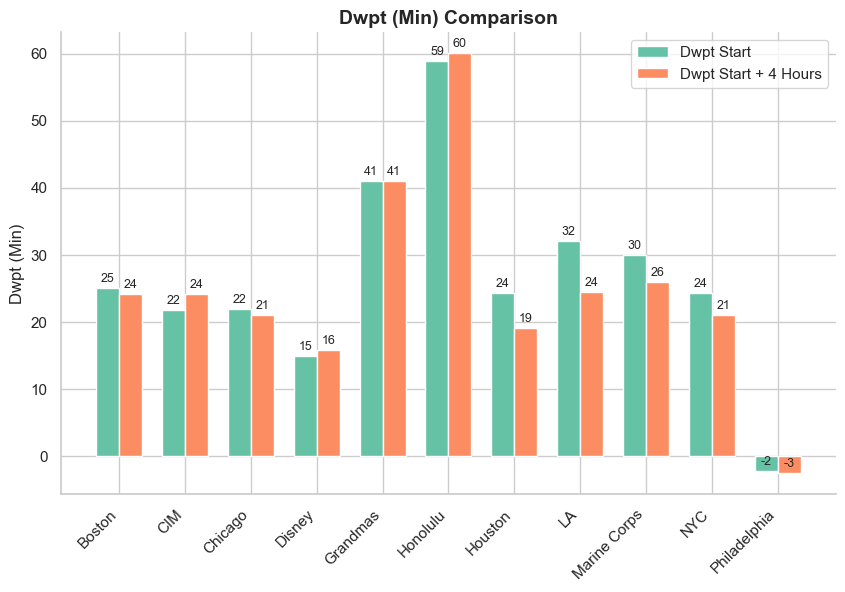

<Figure size 1920x1440 with 0 Axes>

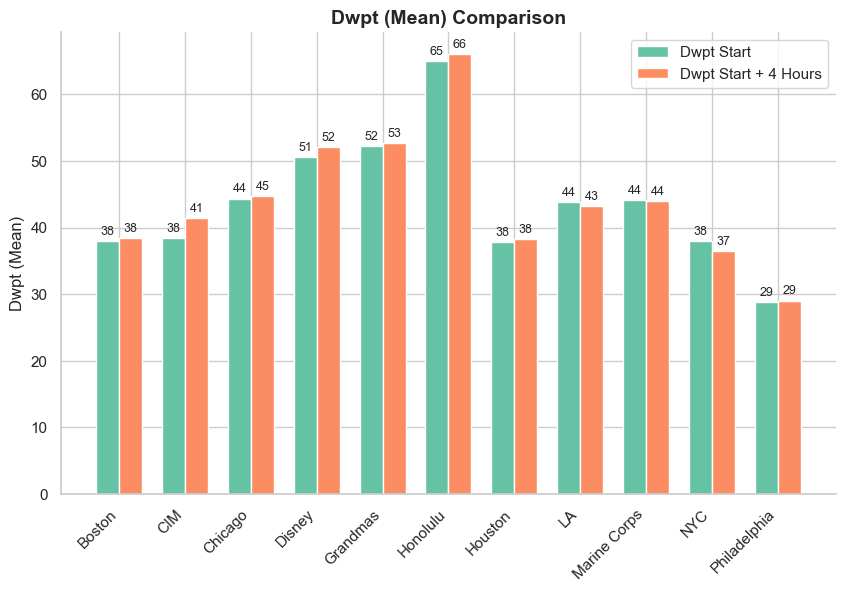

<Figure size 1920x1440 with 0 Axes>

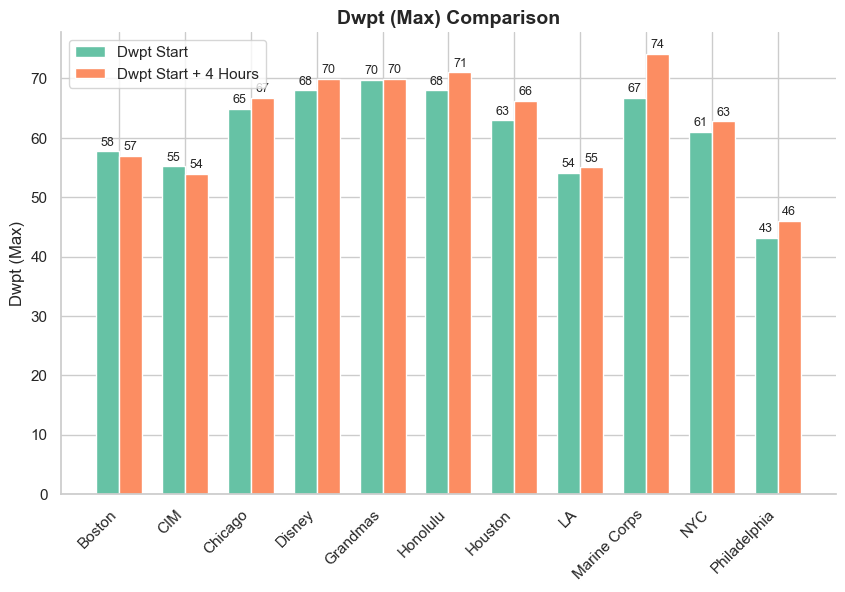

<Figure size 1920x1440 with 0 Axes>

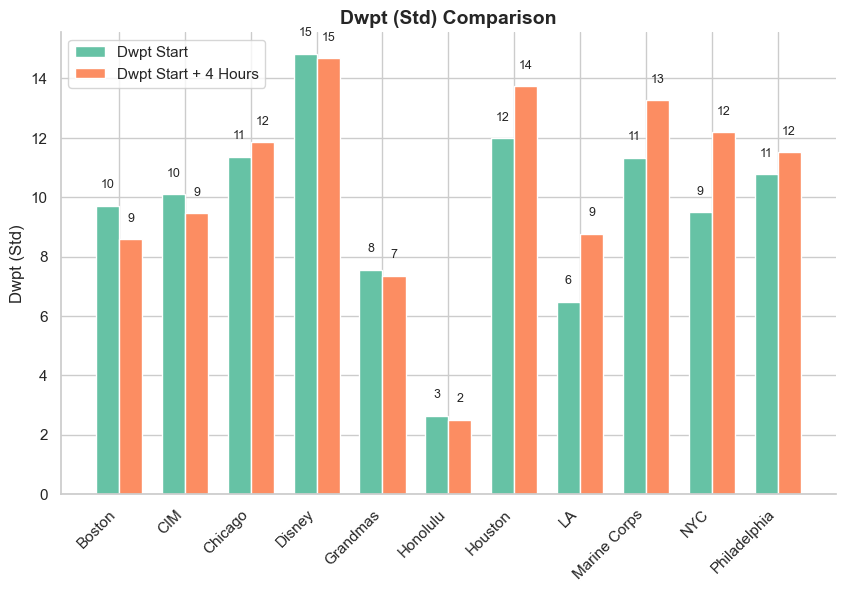

<Figure size 1920x1440 with 0 Axes>

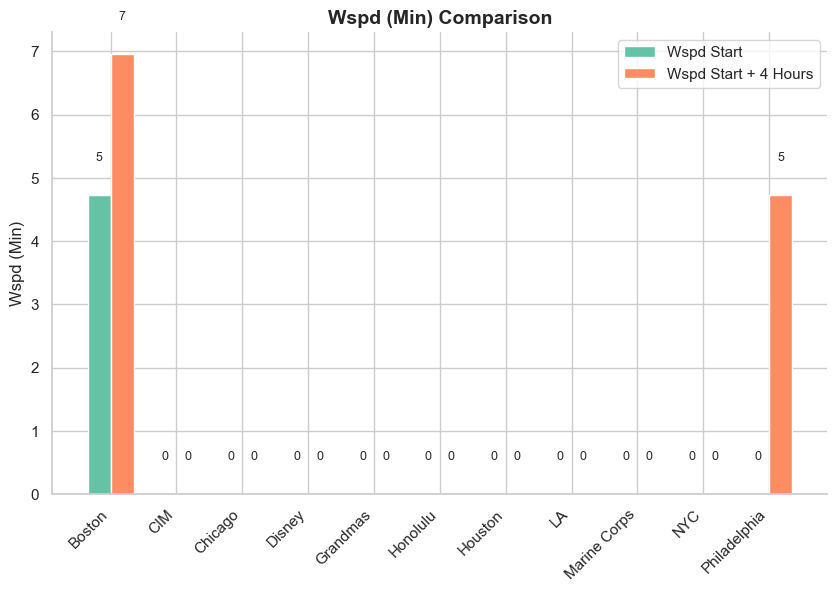

<Figure size 1920x1440 with 0 Axes>

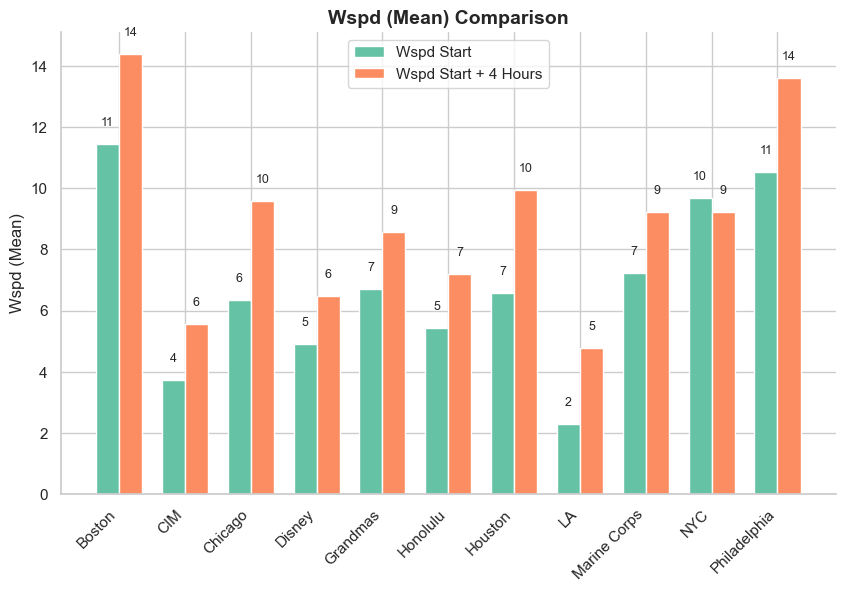

<Figure size 1920x1440 with 0 Axes>

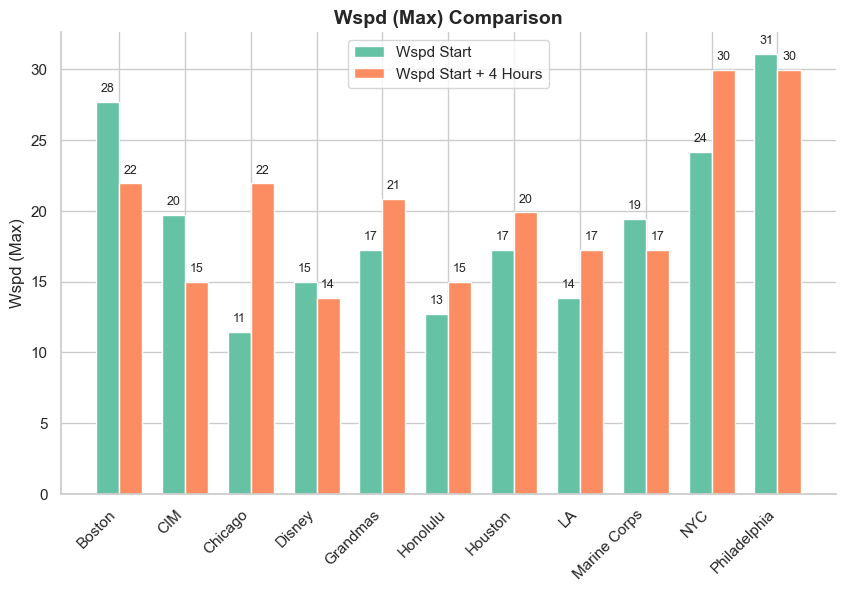

<Figure size 1920x1440 with 0 Axes>

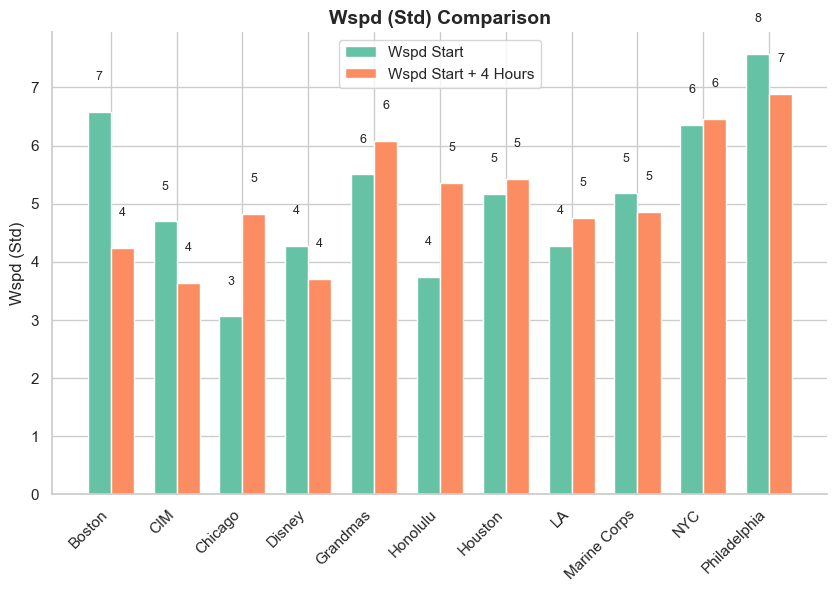

<Figure size 1920x1440 with 0 Axes>

In [92]:
plot_and_save_aggregated_metrics(pivot_df)

In [87]:
pivot_df[('temp_start','max')] - pivot_df[('temp_start','min')]

marathon_name
Boston          34.02
CIM             30.06
Chicago         42.12
Disney          41.04
Grandmas        27.00
Honolulu         8.10
Houston         35.10
LA              23.58
Marine Corps    30.96
NYC             26.46
Philadelphia    28.98
dtype: float64

In [88]:
pivot_df[('temp_start','min')], pivot_df[('temp_start','max')]

(marathon_name
 Boston          39.92
 CIM             28.94
 Chicago         30.92
 Disney          30.02
 Grandmas        44.60
 Honolulu        66.92
 Houston         28.94
 LA              46.40
 Marine Corps    37.04
 NYC             42.08
 Philadelphia    24.98
 Name: (temp_start, min), dtype: float64,
 marathon_name
 Boston          73.94
 CIM             59.00
 Chicago         73.04
 Disney          71.06
 Grandmas        71.60
 Honolulu        75.02
 Houston         64.04
 LA              69.98
 Marine Corps    68.00
 NYC             68.54
 Philadelphia    53.96
 Name: (temp_start, max), dtype: float64)

In [89]:
pivot_df[('dwpt_start_plus_4','max')] - pivot_df[('dwpt_start_plus_4','min')]

marathon_name
Boston          32.94
CIM             29.88
Chicago         45.72
Disney          54.18
Grandmas        28.98
Honolulu        10.98
Houston         47.16
LA              30.60
Marine Corps    48.24
NYC             41.76
Philadelphia    48.60
dtype: float64

In [90]:
pivot_df[('temp_start_plus_4','max')], pivot_df[('temp_start_plus_4','min')]

(marathon_name
 Boston          78.98
 CIM             62.06
 Chicago         82.04
 Disney          73.04
 Grandmas        78.80
 Honolulu        80.96
 Houston         73.04
 LA              84.02
 Marine Corps    75.92
 NYC             73.22
 Philadelphia    59.00
 Name: (temp_start_plus_4, max), dtype: float64,
 marathon_name
 Boston          44.06
 CIM             37.04
 Chicago         37.94
 Disney          30.92
 Grandmas        46.40
 Honolulu        71.96
 Houston         41.00
 LA              51.80
 Marine Corps    48.02
 NYC             48.02
 Philadelphia    28.94
 Name: (temp_start_plus_4, min), dtype: float64)